# Running Monte Carlo Simulations with MC Sim

## Overview

In Chem 280, we wrote a Python package called `mcsim` which can perform Monte Carlo simulation on Lennard Jones fluids.

As a reminder, here are some definitions:

`Monte Carlo Simulation` - A simulation method which relies on random numbers.  
`Lennard Jones` - A model of particle energy which describes van der Waals (nonbonded and noncharged) interactions between particles.  
`configuration` - The set of (x, y, z) coordinates for a system of atoms.

For anyone not in Chem 280, here is a very brief explanation of Monte Carlo simulation - For our Monte Carlo simulation, we generate some initial configuration (set of coordinats) for a system of atoms. The atoms are placed in a box with periodic boundary conditions. We then generate additional configurations of the system of atoms by randomly moving the particles and keeping some configurations. Configurations which result in a lower system energy according to the Lennard Jones model are kept. We also occassionally keep configurations of higher energies based on random numbers (like rolling a dice, if above a certain value, we will keep the configuration). This is an extremeley simple explanation of molecular Monte Carlo, but it will be good enough for this exercise if you are not familiar with the method.

We can analyze the generated configurations for system properties like pressure or for structural information, like the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function). This notebook shows how to use the `mcsim` package to run a Monte Carlo simulation.

## Steps for running a simulation

1. **Import needed packages**
1. **Set system parameters** - For each simulation, you will set the number of system parameters number of atoms, system density, and  temperature.
1. **Set simulation parameters** - You will set parameters for the simulation. These are the number of steps (or trial moves), the simulation cutoff, and the maximum particle displacement.
    - Number of steps - the number of configuration generation trials. These are accepted or rejected based on the energy of the system.
    - Simulation cutoff - The maximum length for which to calculate nonbonded interactions.
    - Maximum particle displacement - The maximum distance a particle can be moved in any direction when configurations are proposed.
1. **Equilibration simulation** - A simulation run which is used to allow the system to acheive equilibrium. You will see the system energy settling during this simulation.
1. **Production simulation** - Run after the equilibration. The system is at a stable state, so we can analyze the results.

## Exercises

Even though we didn't use our program much in Chem 280, we did actually write a working molecular simulation code. In this lab, you will use the molecular simulation code we wrote to analyze a sytem of particles under different conditions. We will look at the effect of system temperature and density, and consider how equilibration length affects the results observed for the simulation. **This notebook is written so that you will only be modifying the system parameters and type simulation parameters in cell 2.**

The `run_simulation` command returns a list of generated configurations. The simulation prints the step number, the system energy, and the system pressure to a csv file.

This notebook will generate some programming concepts you haven't seen before, but don't worry, we will learn about them in Chem 274A. Try not to get bogged down in the lines of code, but instead look at how we would run a simulation and the simulation results. We are happy to answer any coding questions you have, however!

1. Run the simulation with the current parameters. You shouldn't have to modify any code to do this. Take note of the comments and the graphs generated.
    The starting parameters are:
        - num_atoms = 500
        - reduced_temperature = 0.9
        - density = 0.9
        - 100000 steps for equilibration (freq = 10000)
        - 100000 steps for production (freq = 10000)
2. Run a simulation with the following parameters:
        - num_atoms = 500
        - reduced_temperature = 0.9
        - density = 0.9
        - 1 step for equilibration (freq = 1)
        - 1000 steps for production (freq = 100)
3. What are the difference you see between (1) and (2). Why do you think these differences occur? For your RDF, you will see nonzero values close to zero distance. Does this make sense physically? (as in, would particles ever be this close?)
4. Repeat (1) with a system density of `0.009` and compare the RDF. Note the location of the peak and the shape of the graph. **challenge** Plot two rdfs on the same plot. This will require you to save the rdfs with different variable names and to change the name of the saved figure.
5. Repeat (1) or (4) with a system temperature of `1.5` and compare the RDF. **challenge** Plot the two rdfs on the same plot. This will require you to save the rdfs with different variable names and to change the name of the saved figure.
5. **optional** Try (1) and (2) again using `generate_cubic_lattice` instead of `generate_random_coordinates`. The functions behave the same, you should only have to change the function name. Do you notice any differences in results?


Record your answers in a `README.md` file in this repository.

In [2]:
# All of the imports we will need in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# Import the needed functions from our mcsim package.
from mcsim import run_simulation, generate_cubic_lattice, generate_random_coordinates
from mcsim.analysis import time_average_rdf

%matplotlib inline

In [62]:
# Set system parameters - you will modify this
num_atoms = 500
reduced_temperature = 0.9
density = 0.009

# Set simulation parameters - you will modify this
num_steps = 100000
max_displacement = 0.1 
cutoff = 3
freq = 10000


# Generate the initial configuration
atomic_coordinates, box_length = generate_random_coordinates(num_atoms, density)

# Convert to numpy array
atomic_coordinates = np.array(atomic_coordinates)

In [63]:
# Run an equilibration simulation
equilibration_coords = run_simulation(deepcopy(atomic_coordinates), 
                                              box_length, cutoff, 
                                              reduced_temperature, 
                                              num_steps, freq=freq, filename="equilibration.csv")

Step Number,Energy per particle,Pressure
0, 0.033776742039335984, 0.011445315663322799
10000, -0.05516106173976052, 0.007880385881665022
20000, -0.05514738007525601, 0.008022542037417993
30000, -0.0707588232634106, 0.007743059249929496
40000, -0.06800673505233092, 0.007842212797321002
50000, -0.06648891347836387, 0.007887295050904857
60000, -0.0601040923489546, 0.007874940198274272
70000, -0.06807622904706656, 0.0078069928336143
80000, -0.05758231200892152, 0.00825867242177251
90000, -0.0636304452445189, 0.007601797193756844


Now that we've run our equilibration, we want to examine the energies to make sure our system has reached a stable state. Our equilibration wrote a file called "equilibration.csv". We will read it using pandas and plot it using matplotlib.

In [64]:
equil = pd.read_csv("equilibration.csv")
equil.head()

EmptyDataError: No columns to parse from file

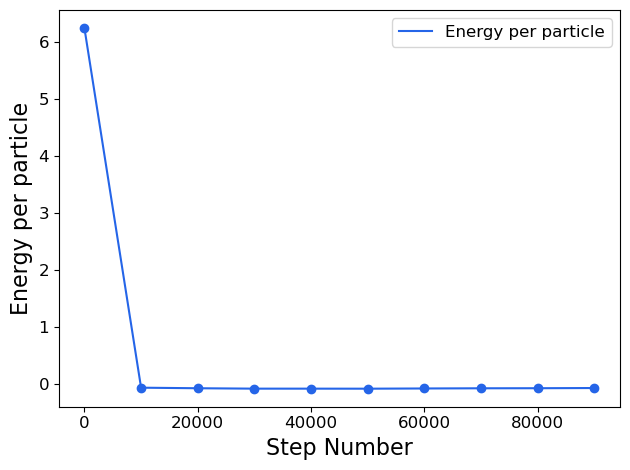

In [ ]:
## Some code for making a pretty plot with matplotlib

fig, ax = plt.subplots()
ax.plot("Step Number", "Energy per particle", data=equil, color="#2565E8")
ax.scatter("Step Number", "Energy per particle", data=equil, color="#2565E8", label=None)
ax.set_ylabel('Energy per particle', fontsize=16)
ax.set_xlabel('Step Number', fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.legend(fontsize=12)
fig.tight_layout()


After our system as reached a steady energy, we are ready to run simulations which we will analyze. These are called "production" simulations.

In [67]:
# Set simulation parameters
num_steps = 100000
max_displacement = 0.1 
cutoff = 3
freq = 10000

# One way to keep several different files programmatically is to use a variable file name.
# we create a variable file name using the system parameters.
# This way, you can modify your simulation notebook and rerun without fear of
# losing results you already have!
filename = f"T_{reduced_temperature}_density_{density}_nsteps_{num_steps}".replace(".", "p")

# Production

last_frame = deepcopy(equilibration_coords[-1])
    
production_coordinates = run_simulation(last_frame, box_length, 
                                        cutoff, reduced_temperature, 
                                        num_steps, freq=freq, filename=f"production_{filename}.csv")

Step Number,Energy per particle,Pressure
0, -0.06363044524451941, 0.007601797193756844
10000, -0.07197116140273714, 0.007863426737525056
20000, -0.06693169433715243, 0.007497740577289522
30000, -0.06993294271212681, 0.007774092916387892
40000, -0.06375223871797575, 0.007552188392784441
50000, -0.06423883475378944, 0.007525437370900744
60000, -0.07760292104348632, 0.007848465940330175
70000, -0.07403695065681713, 0.007509395867607966
80000, -0.07993718803224771, 0.007744090956689427
90000, -0.07886448886190245, 0.00809960119331444


We will analyze our configurations to determine the radial distribution function. The radial distribution function has particular shapes depending on the phase (solid, liquid, gas) so the RDF helps us to determine the phase of our material.

In [68]:
rdf_lt = time_average_rdf(production_coordinates, box_length, num_atoms, box_length/2)

In [55]:
rdf_ht = time_average_rdf(production_coordinates, box_length, num_atoms, box_length/2)

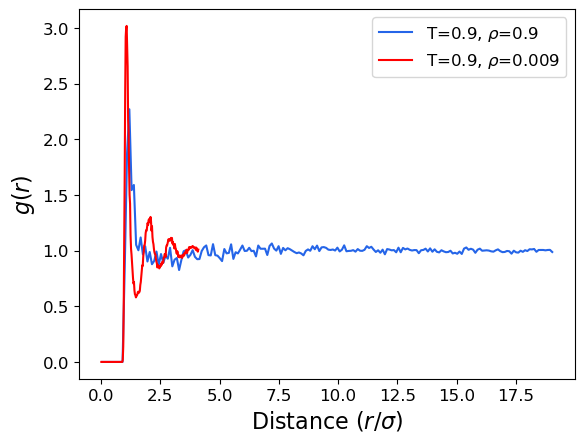

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rdf_lt[0], rdf_lt[1], label=rf'T=0.9, $\rho$=0.9', color="#2565E8")
ax.plot(rdf_ht[0], rdf_ht[1], label=rf'T={reduced_temperature}, $\rho$={density}', color="red")
ax.set_ylabel(r'$g(r)$', fontsize=16)
ax.set_xlabel(r'Distance ($r/\sigma$)', fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.legend(fontsize=12)

#plt.savefig(f'{filename}.png', dpi=300)
plt.savefig(f'q4.png', dpi=300)

### Q3. What are the difference you see between (1) and (2). Why do you think these differences occur? For your RDF, you will see nonzero values close to zero distance. Does this make sense physically? (as in, would particles ever be this close?)

In (1), we allow our system to equilibrate over a large amount of steps/time and stored configurations at a large freq rate. The final equilibrated energy also significantly lower than it initial random configuration energy. While in (2), we didn't allow the system to equilibrate thus the final energy magnitude is on the order of $10^{11}$. The rdf for (2) is significantly different and unphysical since $g(r) > 0 at $distances < 1.0$. This implies that there's a nonzero density of within the particle radius. This is likely due to the fact we generate random system and then don't allow the system to equilibrate to a stable configuration.

### Q4. Repeat (1) with a system density of `0.009` and compare the RDF. Note the location of the peak and the shape of the graph.

![q4](https://user-images.githubusercontent.com/4152448/187575527-a5a59c23-0bae-4523-91af-e3e8706a4132.png)

At lower system densities, our local density near ~1 ($r/\rho$) is greater than at higher densities. This is probably due the fact that the number of particles at ~1 ($r/\rho$) will be relatively constant regardless of the system (bulk) density. 

### Q5. Repeat (1) or (4) with a system temperature of `1.5` and compare the RDF.

![q5](https://user-images.githubusercontent.com/4152448/187574850-8e699f4b-cf9e-451a-a390-f4666b425278.png)

As the temperature increased, the peak at ~ 1.2 ($r/\rho$) decreases meaning the density relative to the bulk density decreased. This is expected since at higher temperatures particles have more energy and thus have a higher velocity. Thus particles will be less correlated to one another. Basically, the curve will broaden and I believe approach gas as temperature increases.

## Bonus - 3D Visualization of our final system

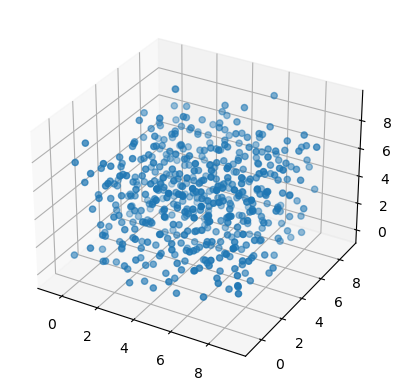

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

final_coordinates = production_coordinates[-1]
x = final_coordinates[:, 0]
y = final_coordinates[:, 1]
z = final_coordinates[:, 2]

ax.scatter(x, y, z, marker='o')